# Retirement Planner

---

## Environment Setup

In [2]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [3]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [4]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [6]:
## Columns are confusing me, I am renaming them..
df.columns = ["AGG_Close", "SPY_Close"]

# Display sample data
df.tail()

,AGG_Close,SPY_Close
2019-12-24 00:00:00-05:00,112.375,321.26
2019-12-26 00:00:00-05:00,112.480,322.91
2019-12-27 00:00:00-05:00,112.620,322.86
2019-12-30 00:00:00-05:00,112.630,321.10
2019-12-31 00:00:00-05:00,112.370,321.92


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [7]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns.tail()

,AGG_Close,SPY_Close
2019-12-24 00:00:00-05:00,0.001292,0.000125
2019-12-26 00:00:00-05:00,0.000934,0.005136
2019-12-27 00:00:00-05:00,0.001245,-0.000155
2019-12-30 00:00:00-05:00,0.000089,-0.005451
2019-12-31 00:00:00-05:00,-0.002308,0.002554


In [8]:
# Compute daily volatility
daily_returns.std() 

AGG_Close    0.002089
SPY_Close    0.007820
dtype: float64

In [9]:
# Save the last day's closing price
agg_last_price = df['AGG_Close'][-1]
spy_last_price = df['SPY_Close'][-1]

In [10]:
agg_last_price

112.37

In [11]:
spy_last_price

321.92

### Run simulation

In [12]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [13]:
avg_daily_return_agg = daily_returns.mean()['AGG_Close']
avg_daily_return_spy = daily_returns.mean()['SPY_Close']


std_dev_daily_return_agg = daily_returns.std()['AGG_Close']
std_dev_daily_return_spy = daily_returns.std()['SPY_Close']

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the Monte Carlo Simulation
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]

    # Simulate the returns for 252 * 3 days
    for i in range(number_records):

        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))

        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)

    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)

    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()

    # Set the portfolio weights (40% AGG; 60% SPY)
    weights = [0.4, 0.6]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)

    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000475,1.000537,0.998808,1.005395,1.011797,0.994452,0.997250,1.013277,1.000868,0.995376,...,1.002066,0.992709,1.001800,1.002671,0.996472,1.003160,1.001638,1.006801,0.998172,0.994766
2,1.008876,1.004700,1.003591,0.996711,1.009570,0.994247,0.994213,1.007201,1.000225,0.993035,...,1.005758,0.994517,1.003317,1.006181,0.997472,0.991774,1.002764,1.005409,0.996137,0.998871
3,1.008286,1.004228,1.003771,0.998233,1.007751,0.987669,0.998228,1.001363,1.000230,1.001277,...,1.006771,0.988443,1.004117,1.010565,0.993294,0.994454,1.008272,0.999144,0.998655,1.003329
4,1.013962,1.006575,1.008494,1.002636,1.013663,0.990972,1.003241,0.995493,1.002048,1.006035,...,1.004196,0.992122,1.004723,1.004422,0.994844,0.993782,1.005723,1.002248,0.996963,1.004095


In [14]:
# Check that the simulation ran successfully
portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,192.198632,173.061915,175.536542,137.184495,174.087276,406.898297,103.715503,207.335040,179.851038,154.485316,...,205.794078,209.597094,201.019313,150.405526,211.474529,419.025393,175.585603,465.203342,135.029922,207.278177
7557,191.796295,171.335698,175.073322,137.168852,174.462336,406.829966,103.095585,209.131281,179.936157,153.301078,...,205.522019,208.967028,201.668852,149.199635,211.588511,421.932597,175.990087,466.851578,135.447343,206.876247
7558,191.217898,171.137531,175.864455,137.377557,173.873490,408.572982,103.151109,209.957651,180.769205,153.380322,...,205.679462,209.612623,202.344679,148.768826,212.614164,422.012395,176.024377,463.429554,134.469736,207.289917
7559,190.859975,171.029260,176.121496,137.739761,175.432388,406.560889,102.902693,209.654533,179.742836,153.250418,...,206.056113,210.666825,201.151747,148.821403,213.780900,421.115650,176.285521,462.220129,133.666973,206.401943
7560,192.769939,171.963857,177.992293,138.460439,175.622694,406.595515,102.234885,209.318807,178.367586,153.115371,...,206.850892,209.781981,200.644529,149.216748,214.329392,421.158099,176.158309,459.010501,134.125079,207.485372


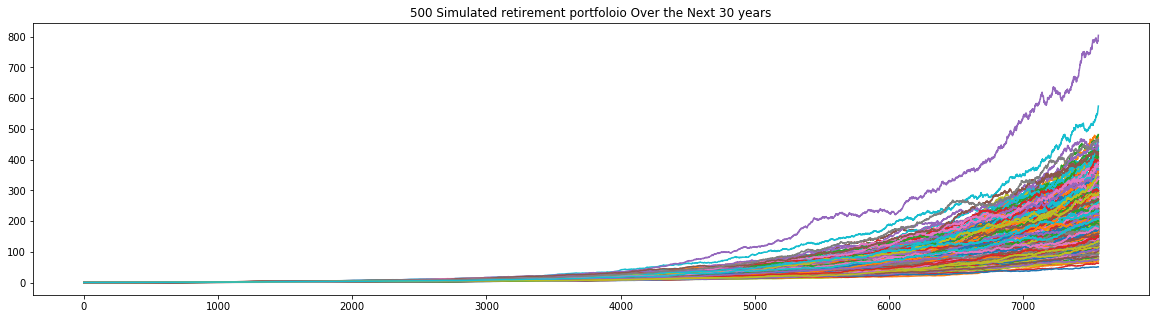

In [15]:
# Visualize the Simulation
plot_title = f"{n+1} Simulated retirement portfoloio Over the Next 30 years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title,figsize=(20,5))

In [16]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# 20th year row ?? (Typo ??)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-11, :]
ending_cumulative_returns.head()

0    191.885348
1    171.775960
2    171.878151
3    137.406385
4    175.694569
Name: 7550, dtype: float64

In [17]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
###  last row -- 30 years
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    192.769939
1    171.963857
2    177.992293
3    138.460439
4    175.622694
Name: 7560, dtype: float64

In [18]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    102.825245
0.95    379.342101
Name: 7560, dtype: float64

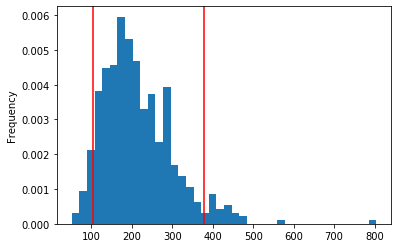

In [19]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=40)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [20]:
# Compute cumulative returns
expected_cumulative_return = ending_cumulative_returns.quantile(q=[0.10, 0.50, 0.90])
expected_cumulative_return

0.1    119.029858
0.5    199.089970
0.9    320.549831
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [21]:
initial_investment=20000
expected_return_10p = round(initial_investment + (initial_investment * expected_cumulative_return.iloc[0]),2)
expected_return_50p = round(initial_investment + (initial_investment * expected_cumulative_return.iloc[1]),2)
expected_return_90p = round(initial_investment + (initial_investment * expected_cumulative_return.iloc[2]),2)

print(f" Expected portfolio returns: \n 10th percentile : {expected_return_10p} \n 50th percentile : {expected_return_50p} \n 90th percentile : {expected_return_90p}")
     

 Expected portfolio returns: 
 10th percentile : 2400597.16 
 50th percentile : 4001799.4 
 90th percentile : 6430996.62


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [22]:
# Set Plaid's projected income
plaid_projected_income = 7389 

# Calculate the 4% withdrawal for the ending return as retirement income


retirement_income = .04 * (expected_return_10p)

# Determine if the retirement income meets or exceeds the current projected income

# plaid_projected_income_at_30 years =  around $11,000 after compounded annual percentage increase  ??? Comparing the original income but if needed can 
#     modify the code to compare with the projected income after 30 years. 

if retirement_income >= plaid_projected_income:
    print(f"You will have ${retirement_income:.2f} in retirement income which is sufficient")
else:
    print(f"You will have ${retirement_income:.2f} in retirement income which is not sufficient")


You will have $96023.89 in retirement income which is sufficient


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [24]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
initial_investment=30000
new_expected_return_10p = round(initial_investment + (initial_investment * expected_cumulative_return.iloc[0]),2)
new_expected_return_50p = round(initial_investment + (initial_investment * expected_cumulative_return.iloc[1]),2)
new_expected_return_90p = round(initial_investment + (initial_investment * expected_cumulative_return.iloc[2]),2)

retirement_income = .04 * (new_expected_return_10p)

print(f" Expected portfolio returns: \n 10th percentile : {new_expected_return_10p} \n 50th percentile : {new_expected_return_50p} \n 90th percentile : {new_expected_return_90p} \n retirement_income (4% at 10p) = {retirement_income} " )
     

 Expected portfolio returns: 
 10th percentile : 3600895.74 
 50th percentile : 6002699.1 
 90th percentile : 9646494.93 
 retirement_income (4% at 10p) = 144035.82960000003 


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [27]:
# Compute projected returns
expected_cumulative_return_new = ending_cumulative_returns.quantile(q=[0.05, 0.50, 0.95])

initial_investment=20000
expected_return_5p = round(initial_investment + (initial_investment * expected_cumulative_return_new.iloc[0]),2)
expected_return_50p = round(initial_investment + (initial_investment * expected_cumulative_return_new.iloc[1]),2)
expected_return_95p = round(initial_investment + (initial_investment * expected_cumulative_return_new.iloc[2]),2)


# Display sample data
print(f" Expected portfolio returns: \n 5th percentile : {expected_return_5p} \n 50th percentile : {expected_return_50p} \n 95th percentile : {expected_return_95p}")
  

 Expected portfolio returns: 
 5th percentile : 2076504.9 
 50th percentile : 4001799.4 
 95th percentile : 7606842.03


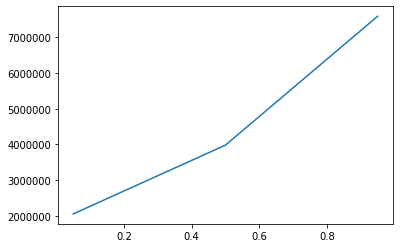

In [30]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
